# Let's go better than baseline

In [33]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import get_scorer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

def impute_missing_values(df):
    # calculate means for all columns for each location
    place_mean = df.groupby(['latitude', 'longitude']).mean()

    # impute missing values with mean of given latitude, longitude from place_mean
    df_imputed = df.groupby(['latitude', 'longitude']).transform(lambda x: x.fillna(x.mean()))
    df_imputed['latitude'] = df['latitude']
    df_imputed['longitude'] = df['longitude'] 
    return df_imputed

def feature_engineering(df):
    df = impute_missing_values(df)
    return df

def train_model(model, raw_df, features, target):
    X_train = feature_engineering(raw_df[features])
    y_train = raw_df[target]
    model.fit(X_train, y_train)
    return model

def get_predictions(model, raw_df, features):
    original_df = raw_df.copy()
    X_test = feature_engineering(raw_df[features])
    original_df[target] = model.predict(X_test)
    return original_df

def magical_constant(df, constant=1.07):
    df[target] *= constant
    return df

def save_submission(df):
    # remove "submission.csv" if it exists
    try:
        os.remove("submission.csv")
    except OSError:
        pass
    df[[id_columns, target]].to_csv("submission.csv", index=False)

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

id_columns = "ID_LAT_LON_YEAR_WEEK"
RANDOM_SEED = 128

target = "emission"
features = list(df_test.columns)
features.remove(id_columns)

# minimal feature set
feature_set_1 = ['latitude', 'longitude', 'year', 'week_no']

# uv only - from EDA & xgboost feature importance
feature_set_2 = feature_set_1 + [ f for f in features if f.startswith('Uv') ]

uv_layer = "UvAerosolLayerHeight_"
uv_index = "UvAerosolIndex_"

feature_set_3 = feature_set_1 + [
    uv_layer + "solar_azimuth_angle",
    uv_layer + "solar_zenith_angle",
    uv_layer + "aerosol_height",
    uv_layer + "aerosol_optical_depth",
    uv_layer + "sensor_zenith_angle",
    uv_layer + "sensor_azimuth_angle",
    uv_index + "solar_azimuth_angle",
]

feature_set_4 = feature_set_3 + [
    "Ozone_O3_column_number_density",
    uv_layer + "aerosol_pressure",
]

feature_sets = [feature_set_1, feature_set_3]

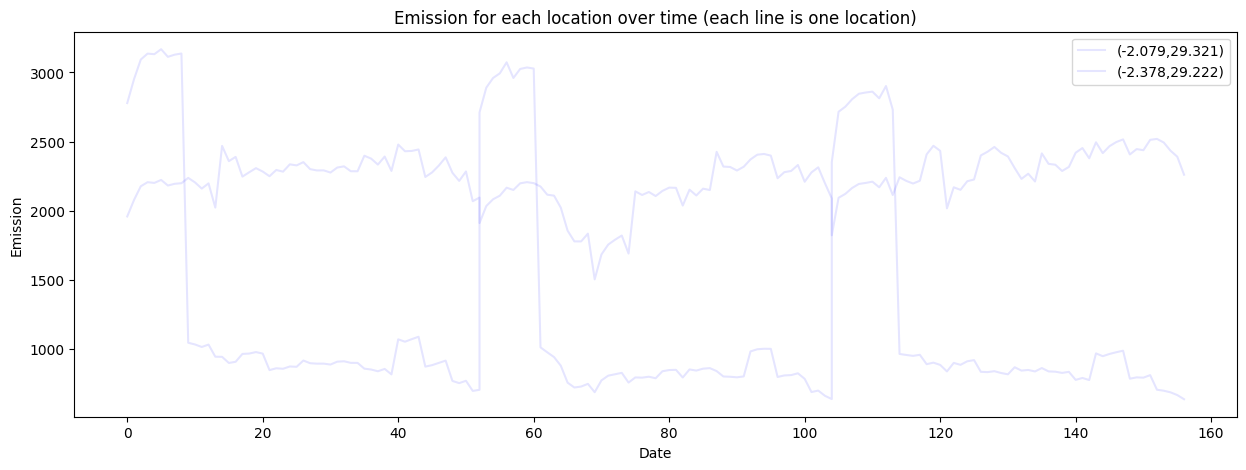

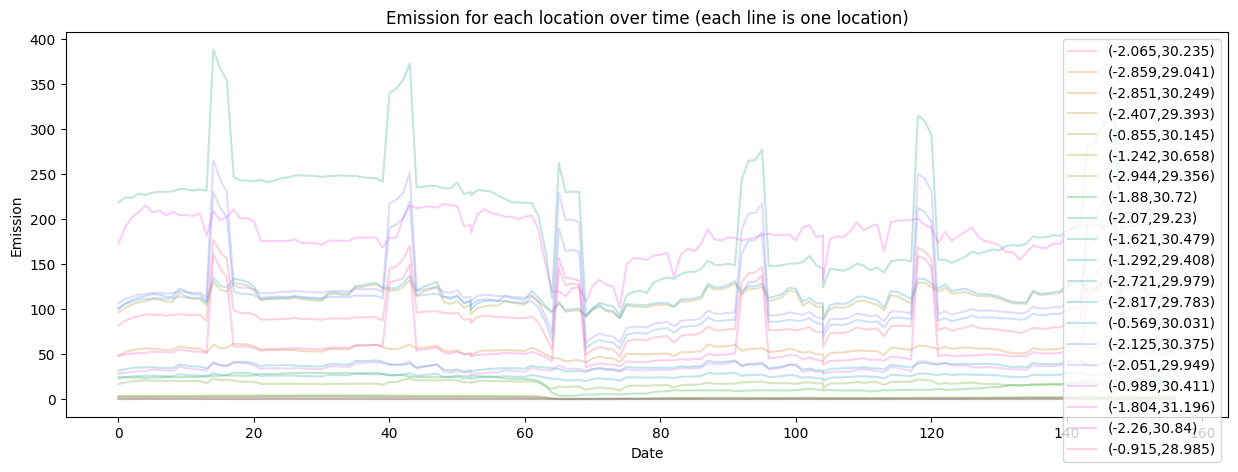

In [37]:

emission_data = df_train.copy()
emission_data['total_week_number'] = emission_data['week_no'] + (emission_data['year'] - 2019) * 52

unique_locations = emission_data.sort_values(by='emission', ascending=False)[['latitude', 'longitude']].drop_duplicates()

# get it in list of tuples
unique_locations = [tuple(x) for x in unique_locations.values]


def plot_emission_for_locations(locations, same_color=True, alpha=0.6):
    fig, ax = plt.subplots(figsize=(15, 5))

    
    cmap = None
    if not same_color:
        cmap = sns.husl_palette(len(locations))

    # for each unique location, plot its emission
    for i, (lat, lon) in enumerate(locations):
        plot_data = emission_data[(emission_data['latitude'] == lat) & (emission_data['longitude'] == lon)]
        color = 'blue'
        if not same_color:
            color = cmap[i]
        ax.plot(plot_data['total_week_number'], plot_data['emission'], label=f'({lat},{lon})', alpha=alpha, color=color)

    ax.set_title('Emission for each location over time (each line is one location)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Emission')
    ax.legend()
    plt.show()


plot_emission_for_locations(unique_locations[:2], same_color=True, alpha=0.1)
plot_emission_for_locations(random.sample(unique_locations[2:], 20), same_color=False, alpha=0.3)

In [21]:
top_data = emission_data[ emission_data['total_week_number'] == 40][['longitude', 'latitude', 'emission']]
top_data = top_data.sort_values(by=['emission'], ascending=False)
top_data

,longitude,latitude,emission
56803,29.222,-2.378,2478.22660
46627,29.321,-2.079,1069.14830
62209,29.801,-2.599,583.52110
58711,28.959,-2.441,512.03450
27070,29.686,-1.514,500.55664
...,...,...,...
72862,29.002,-2.898,0.00000
32158,29.218,-1.682,0.00000
28342,28.568,-1.532,0.00000
43288,28.526,-1.974,0.00000


In [22]:
top_data.head(3)

,longitude,latitude,emission
56803,29.222,-2.378,2478.2266
46627,29.321,-2.079,1069.1483
62209,29.801,-2.599,583.5211


In [23]:
locations_groups = ['A', 'B', 'C', 'D']
top_3_data = top_data.head(3).reset_index(drop=True)

def get_group_for_row(row):
    
    latitude = row['latitude']
    longitude = row['longitude']
    
    if latitude == top_3_data['latitude'][0] and longitude == top_3_data['longitude'][0]:
        return "A"
    elif latitude == top_3_data['latitude'][1] and longitude == top_3_data['longitude'][1]:
        return "B"
    elif latitude == top_3_data['latitude'][2] and longitude == top_3_data['longitude'][2]:
        return "C"    
    return 'D'

def add_groups(df):
    df['group'] = df.apply(get_group_for_row, axis=1)
    return df

def feature_engineering(df):
    df = impute_missing_values(df)
    df = add_groups(df)
    return df

In [24]:
params = {"objective":"reg:squarederror", "max_depth":20, "learning_rate":0.1, "n_estimators":1000, "n_jobs":-1}
xgboost_model = xgb.XGBRegressor(**params)

models = {
    "XGBoost": xgboost_model,
    "RandomForestRegressor": RandomForestRegressor(n_estimators=2000, random_state=RANDOM_SEED, n_jobs=-1)
}

data = []
data_columns = ['model', 'feature_set', 'rmse_train', 'rmse_validation']

model_for_group = {
    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

for name, model in models.items():
    for i, feature_set in enumerate(feature_sets):
        pipeline = make_pipeline(
            SimpleImputer(strategy='median'),
            model
        )

        for group in model_for_group.keys():
            model_for_group[group] = pipeline

        # we split the data into train and test sets based on year - 2019, 2020 is train, 2021 is test
        def split_data(df):
            test = df[(df['year'] == 2021) & (df['week_no'] > 15)]
            # train - df not in test
            train = df[~df.index.isin(test.index)]
            
            return train, test

        df_train_imputed = feature_engineering(df_train[feature_set])
        df_train_imputed[target] = df_train[target]
        train, test = split_data(df_train_imputed)

        for group in model_for_group.keys():
            
            train_group = train[train['group'] == group]
            train_group = train_group.drop(columns=['group'])
            test_group = test[test['group'] == group]
            test_group = test_group.drop(columns=['group'])

            X_train = train_group.drop(columns=[target])
            y_train = train_group[target]

            X_test = test_group.drop(columns=[target])
            y_test = test_group[target]
            print(f"Training {name}, group {group} on feature set {i}...")
            model_for_group[group].fit(X_train, y_train)
            y_pred = model_for_group[group].predict(X_test)

        # calculate rmse
        rmse_train = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
        rmse_validation = np.sqrt(mean_squared_error(y_test, y_pred))
        data.append([name, i, rmse_train, rmse_validation])

Training XGBoost, group A on feature set 0...
Training XGBoost, group B on feature set 0...
Training XGBoost, group C on feature set 0...
Training XGBoost, group D on feature set 0...


KeyboardInterrupt: 

In [ ]:
df_results = pd.DataFrame(data, columns=data_columns)
df_results.sort_values(by='rmse_validation')

In [ ]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=2000, random_state=RANDOM_SEED, n_jobs=-1)
)

print("Training model")
model = train_model(pipeline, df_train, feature_set_1, target)

print("Getting predictions")
output_test_df = get_predictions(model, df_test, feature_set_1)

print("Applying magical constant")
output_test_df = magical_constant(output_test_df, 1.07)

print("Saving submission file")
save_submission(output_test_df)

In [ ]:
#! kaggle competitions submit -c playground-series-s3e20 -f submission.csv -m "First submission"